# Black-Scholes option pricing with Monte Carlo on Python

The purpose of this notebook is to explore different methods for the valuation of options within the framework of the Black-Scholes pricing model with the use of Python. In particular, we will rely on Monte Carlo methods for the pricing of european call options, and compare the results with those obtained through the exact Black-Scholes solution. 

As a minimal introduction, the Black-Scholes model states that the asset prices as a function of time, $S(t)$, follows a geometric brownian motion:
$$
dS = S \mu dt + S \sigma dz\,.
$$

Let then have an option $f$, which will be a function of $S$ and $t$. Then, the process followed by this option will be described by:
$$
df = \left( \frac{\partial f}{\partial S}\mu S + \frac{\partial f}{\partial t} + \frac{1}{2}\sigma^{2}S^{2}\frac{\partial^{2}f}{\partial S^{2}}\right)dt + \frac{\partial f}{\partial S}\sigma S dz\,.
$$

Let us consider the following portfolio $\Pi$, composed of the option $f$ and a certain amount $\Delta$ of the underlying $S$:
$$
\Pi = f + \Delta S\,.
$$
Then, this portfolio will follow the process:
$$
d\Pi = - df +\frac{\partial f}{\partial S} dS = \left( -\frac{\partial f}{\partial t} - \frac{1}{2}\sigma^{2}S^{2}\frac{\partial^{2} f}{\partial S^{2}} \right)dt\,,
$$
We we have set: 
$$
\Delta = \partial f / \partial S\,.
$$
We notice that, in the equation for $d\Pi$, the stochastic part of the process $dz$ is no longer present. This eliminates risk from the portfolio, which will therefore earn a risk-free rate $r$:
$$
d\Pi = r \Pi dt\,.
$$
Combining these equations for $d\Pi$, we end up with:
$$
\frac{\partial f}{ \partial t} + r\,S\frac{\partial f}{\partial S} +\frac{1}{2}\sigma^{2}S^{2}\frac{\partial^{2}f}{\partial S^{2}} = r\,f\,,
$$
which is the Black-Scholes equation.

The solution of the Black-Scholes equation for an european call option $C(S,t)$, given the maturity $T$ and strike price $X$ is given by:
$$
C(S,t) = S\, N(d_{1}) - X\,e^{-r(T-t)}N(d_{2})\,,
$$
where:
$$
d_{1} = \frac{\ln(S/X) + \left(r + \frac{\sigma^{2}}{2}\right)\left(T-t\right)}{\sigma\sqrt{T-t}}\,,
$$
$$
d_{2} = \frac{\ln(S/X) + \left(r - \frac{\sigma^{2}}{2}\right)\left(T-t\right)}{\sigma\sqrt{T-t}}\,,
$$
and where $N(d)$ is the cumulative normal distribution:
$$
N(d)= \frac{1}{\sqrt{2\pi}}\int_{-d}^{\infty} dx\; e^{-x^{2}/2}\,.
$$

# Exact Solution

Let us first focus on the exact solution for the for the price of the call option $C(S,t)$.

In [15]:
import numpy as np
import pandas as pd
from scipy import log,exp,sqrt,stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
plt.style.use('fivethirtyeight')
import numpy.random as npr
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

We define the exact solution directly:

In [16]:
def BS_Call_Exact(S,X,r,sigma,T,t):

    d1 = (np.log(S/X)+(r+((sigma**2)/2))*(T-t))/(sigma*np.sqrt((T-t)))
    d2 = d1-sigma*np.sqrt((T-t))
    
    ST = S*stats.norm.cdf(d1) - X*np.exp(-r*(T-t))*stats.norm.cdf(d2)
    
    return ST

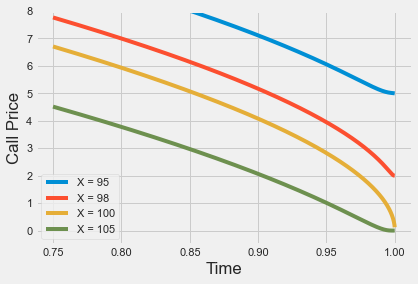

In [17]:
t = np.arange(0.75, 1.0, 0.0001)
sns.lineplot(x=t, y=BS_Call_Exact(100,95,0.06,0.3,1,t), label = 'X = 95')
sns.lineplot(x=t, y=BS_Call_Exact(100,98,0.06,0.3,1,t), label = 'X = 98')
sns.lineplot(x=t, y=BS_Call_Exact(100,100,0.06,0.3,1,t), label = 'X = 100')
sns.lineplot(x=t, y=BS_Call_Exact(100,105,0.06,0.3,1,t), label = 'X = 105')



plt.xlabel('Time')
plt.ylabel('Call Price')
plt.ylim(-0.5,8)

plt.legend()
plt.show()

We plot some solutions $C$ as function of $t$. We choose $S = 100$ and use $X=95,98,100,105$. In the remaining of this notebook, we will always set $T = 1$ $r = 0.06$, $\sigma = 0.3$.

In particular, for $T-t = 0$, we have the standard funcion for the call option at maturity:

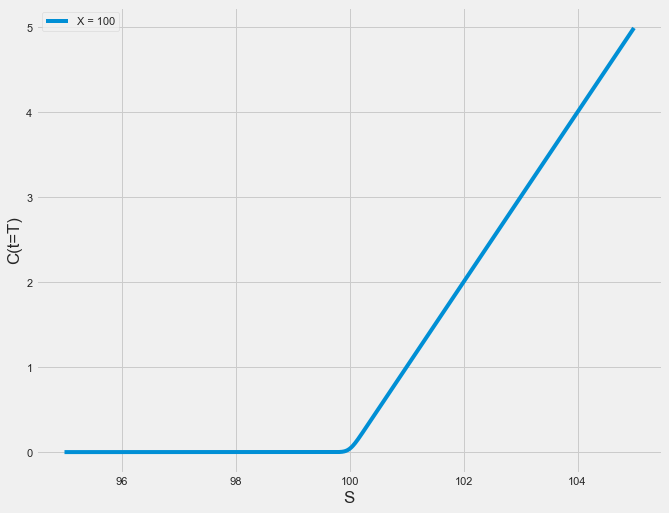

In [18]:
s = np.arange(95, 105, 0.01)

plt.figure(figsize = (10,8))
sns.lineplot(x=s,y=BS_Call_Exact(s,100,0.06,0.3,1,0.99999), label = 'X = 100')

plt.xlabel('S')
plt.ylabel('C(t=T)')

plt.legend()
plt.show()

# Monte Carlo Method

An alternate way to compute the call option price is to use Monte Carlo methods. The starting point is taking the Brownian motion equation for the underlying stock $S(t)$:
$$
dS = S\,r dt +S\sigma dz\,,
$$
where we have set $\mu = r$, since we are working in a risk-free setting. This equation can be discretized by an Euler scheme. By doing this, we obtain the level of stock index $S_{T}$ at a future $T$ given a level $S_{t}$ as: 
$$
S_{T} = S_{t}\exp\left(\left(r-\frac{1}{2}\sigma^{2}\right)(T-t) +\sigma \sqrt{T-t}\,z\right)\,,
$$
where $z$ is an stochastic variable following a normal distribution. 

We can simulate the process for $S_{T}$ using the Monte Carlo method. As an example, we set $r=0.06$, $\sigma = 0.3$, $T-t = 1$, $S_{t} = 100 $. We make $I = 100000$ iterations and choose $M = 100$ intervals for the time interval discretization.

In [19]:
r=0.06
sigma = 0.3
T = 1.0
S0 = 100

I = 100000
M = 100

dt = T/M

S = np.zeros((M+1, I))
S[0] = S0
print(S)

for t in range(1,M+1):
    S[t] = S[t-1]*np.exp((r -0.5*sigma**2)*dt +sigma*np.sqrt(dt)*npr.standard_normal(I))   

[[100. 100. 100. ... 100. 100. 100.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]


We notice that $S_{i}$ has a log-normal distribution:

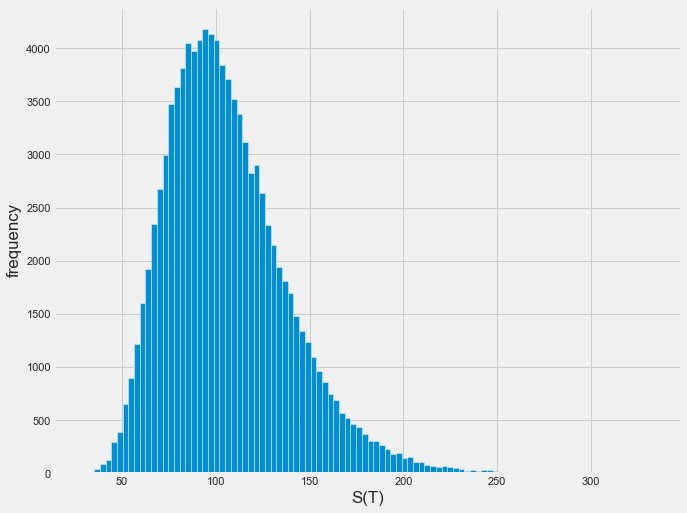

In [20]:
plt.figure(figsize=(10, 8))
plt.hist(S[-1], bins=100)
plt.xlabel('S(T)')
plt.ylabel('frequency')
plt.show()

We also note that $S_{t}$ follows a geometric brownian motion:

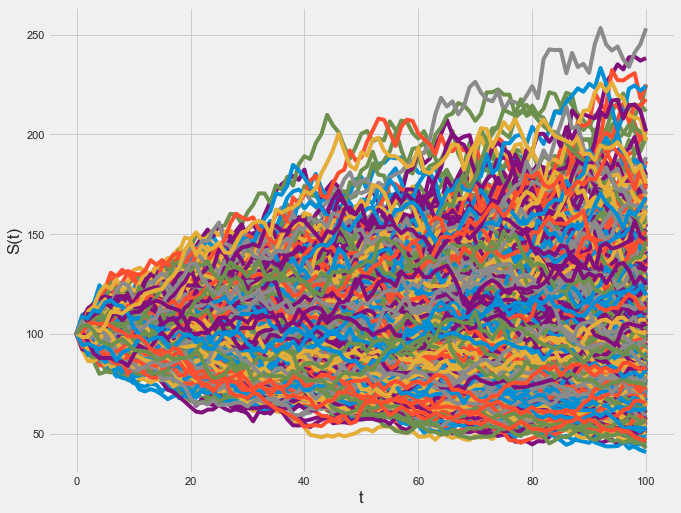

In [21]:
plt.figure(figsize=(10, 8))
plt.plot(S[:, :1000])
plt.xlabel('t')
plt.ylabel('S(t)')
plt.show()

We now that, in the case of a call option, the payoff function at maturity $T$ is given by:
$$\
h(S_{T}) = \max \left( S_{T}-X,0\right)\,.
$$
Then, in the particular case of a risk-free setting, it can be shown that the call option price is given by:
$$
C(T)  = e^{-r(T-t)}\int_{-\infty}^{\infty}dS_{T}\,h(S_{T})\,q(S_{T})\,,
$$
where $q(S)$ is a probability density for the equivalent martingale process to $S_{t}$. This integral can actually be discretized, yielding:
$$
C(T) = e^{-r(T-t)}\frac{1}{I}\sum_{i = 1}^{I}h(S_{T}^{i})\,,
$$
where the sum is taken over a collection $S_{T}^{i}$ following a geometric brownian motion that can be generated by Monte Carlo simulation.

In [22]:
def BS_Call_MC(S,X,r,sigma,T,t,I):
    
    data = np.zeros((I, 2))
    
    z = np.random.normal(0, 1, [1, I])
    
    #z = npr.standard_normal(I)
    
    ST = S*np.exp((T-t)*(r - 0.5*sigma**2)+sigma*np.sqrt(T-t)*z)
    
    data[:,1] = ST - X
    
    average = np.sum(np.amax(data, axis=1))/float(I)
    
    return np.exp(-r*(T-t))*average

We compare the Monte Carlo result for various values and see that there is good agreement:

In [23]:
print('Monte Carlo:',BS_Call_MC(100,95,0.06,0.3,1,.999,100000))
print('Exact: ',BS_Call_Exact(100,95,0.06,0.3,1,.999))

Monte Carlo: 4.998292770260438
Exact:  5.005699833982007


In [24]:
print('Monte Carlo:',BS_Call_MC(100,95,0.06,0.3,1,.75,100000))
print('Exact: ',BS_Call_Exact(100,95,0.06,0.3,1,.75))

Monte Carlo: 9.526689954653797
Exact:  9.548802012535894


We can plot how the value of the Monte Carlo call option converges to the exact value as the number of iterations increases:

C:\Users\jean\AppData\Local\Temp\ipykernel_14940\3026869226.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Iter': i, 'BSc': BS_Call_MC(100,95,0.06,0.3,1,0.75,i)}, ignore_index=True)
C:\Users\jean\AppData\Local\Temp\ipykernel_14940\3026869226.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Iter': i, 'BSc': BS_Call_MC(100,95,0.06,0.3,1,0.75,i)}, ignore_index=True)
C:\Users\jean\AppData\Local\Temp\ipykernel_14940\3026869226.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Iter': i, 'BSc': BS_Call_MC(100,95,0.06,0.3,1,0.75,i)}, ignore_index=True)
C:\Users\jean\AppData\Local\Temp\ipykernel_14940\3026869226.py:5: FutureWarning: The frame.append method is deprecated an

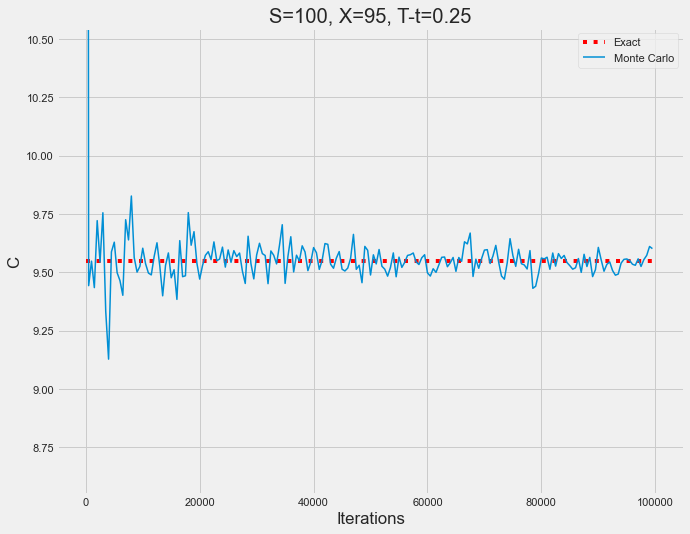

In [25]:
df = pd.DataFrame(columns=['Iter','BSc'])

for i in range(1, 100000, 500):
    
    df = df.append({'Iter': i, 'BSc': BS_Call_MC(100,95,0.06,0.3,1,0.75,i)}, ignore_index=True)


plt.figure(figsize=(10,8))

plt.hlines(BS_Call_Exact(100,95,0.06,0.3,1,0.75),xmin=0,xmax= 100000,linestyle='dotted',colors='red',label = 'Exact')
plt.plot(df.set_index('Iter'),lw = 1.5, label = 'Monte Carlo')

plt.title('S=100, X=95, T-t=0.25')
plt.xlabel('Iterations')
plt.ylabel('C')
plt.ylim(BS_Call_Exact(100,95,0.06,0.3,1,0.75)-1,BS_Call_Exact(100,95,0.06,0.3,1,0.75)+1)
plt.legend()
plt.show()

C:\Users\jean\AppData\Local\Temp\ipykernel_14940\2523857121.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Iter': i, 'BSc': BS_Call_MC(100,95,0.06,0.3,1,0.99,i)}, ignore_index=True)
C:\Users\jean\AppData\Local\Temp\ipykernel_14940\2523857121.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Iter': i, 'BSc': BS_Call_MC(100,95,0.06,0.3,1,0.99,i)}, ignore_index=True)
C:\Users\jean\AppData\Local\Temp\ipykernel_14940\2523857121.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Iter': i, 'BSc': BS_Call_MC(100,95,0.06,0.3,1,0.99,i)}, ignore_index=True)
C:\Users\jean\AppData\Local\Temp\ipykernel_14940\2523857121.py:5: FutureWarning: The frame.append method is deprecated an

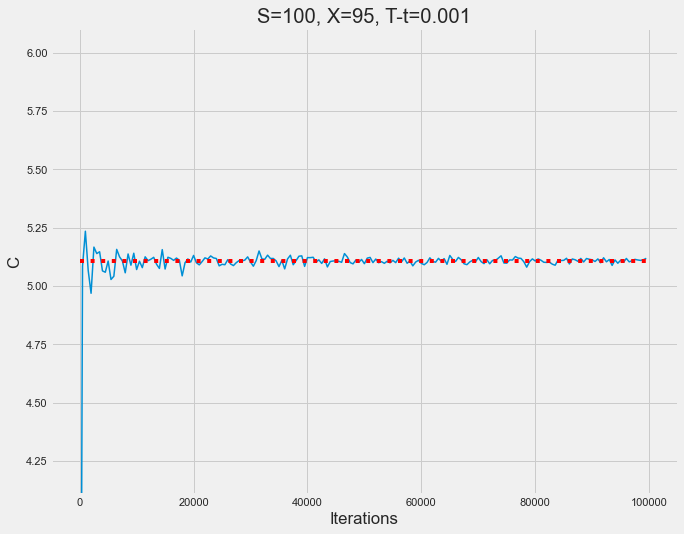

In [26]:
df = pd.DataFrame(columns=['Iter','BSc'])

for i in range(1, 100000, 500):
    
    df = df.append({'Iter': i, 'BSc': BS_Call_MC(100,95,0.06,0.3,1,0.99,i)}, ignore_index=True)


plt.figure(figsize=(10,8))

plt.plot(df.set_index('Iter'),lw = 1.5)
plt.hlines(BS_Call_Exact(100,95,0.06,0.3,1,0.99),xmin=0,xmax= 100000,linestyle='dotted',colors='red')

plt.title('S=100, X=95, T-t=0.001')
plt.xlabel('Iterations')
plt.ylabel('C')
plt.ylim(BS_Call_Exact(100,95,0.06,0.3,1,0.99)-1,BS_Call_Exact(100,95,0.06,0.3,1,0.99)+1)

plt.show()

Finally, we plot the Monte Carlo call option as a function of time and compare it with the exact result, for the values $S =100$ and $X =95,\,98,\,100,\,105$.

C:\Users\jean\AppData\Local\Temp\ipykernel_14940\2306251930.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'t': i, '95': BS_Call_MC(100,95,0.06,0.3,1,i,100000),'98': BS_Call_MC(100,98,0.06,0.3,1,i,100000),'100': BS_Call_MC(100,100,0.06,0.3,1,i,100000),'105': BS_Call_MC(100,105,0.06,0.3,1,i,100000)}, ignore_index=True)
C:\Users\jean\AppData\Local\Temp\ipykernel_14940\2306251930.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'t': i, '95': BS_Call_MC(100,95,0.06,0.3,1,i,100000),'98': BS_Call_MC(100,98,0.06,0.3,1,i,100000),'100': BS_Call_MC(100,100,0.06,0.3,1,i,100000),'105': BS_Call_MC(100,105,0.06,0.3,1,i,100000)}, ignore_index=True)
C:\Users\jean\AppData\Local\Temp\ipykernel_14940\2306251930.py:6: FutureWarning: The frame.append method is deprecated and will be removed f

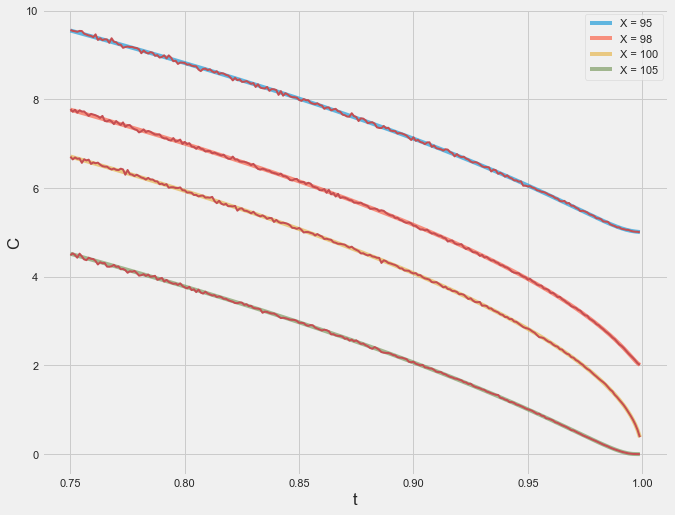

In [27]:
df = pd.DataFrame(columns=['t','95','98','100','105'])
t = np.arange(0.75, 1.0, 0.001)

for i in t:
    
    df = df.append({'t': i, '95': BS_Call_MC(100,95,0.06,0.3,1,i,100000),'98': BS_Call_MC(100,98,0.06,0.3,1,i,100000),'100': BS_Call_MC(100,100,0.06,0.3,1,i,100000),'105': BS_Call_MC(100,105,0.06,0.3,1,i,100000)}, ignore_index=True)


plt.figure(figsize=(10,8))
plt.plot(t,BS_Call_Exact(100,95,0.06,0.3,1,t),alpha=0.6, label = 'X = 95')
plt.plot(t,BS_Call_Exact(100,98,0.06,0.3,1,t),alpha=0.6, label = 'X = 98')
plt.plot(t,BS_Call_Exact(100,100,0.06,0.3,1,t),alpha=0.6, label = 'X = 100')
plt.plot(t,BS_Call_Exact(100,105,0.06,0.3,1,t),alpha=0.6, label = 'X = 105')

plt.plot(df['t'],df['95'],lw=2,c='r')
plt.plot(df['t'],df['98'],lw=2,c='r')
plt.plot(df['t'],df['100'],lw=2,c='r')
plt.plot(df['t'],df['105'],lw=2,c='r')

plt.legend()
plt.xlabel('t')
plt.ylabel('C')

plt.show()